In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime as dt
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from  InvarianceTestEllipsoid import InvarianceTestEllipsoid
from autocorrelation import autocorrelation
from scipy import stats
import scipy.signal as sig
import statsmodels.api as sm

Tin = pd.read_pickle("C:\\Users\\islipd\\Documents\\Thesis Notebooks\\Tout.pkl")

eta = pd.read_pickle("C:\\Users\\islipd\\Documents\\Thesis Notebooks\\Tinnov.pkl")

Pin = pd.read_pickle("C:\\Users\\islipd\\Documents\\Thesis Notebooks\\Pout.pkl")

full_data = pd.read_pickle("C:\\Users\\islipd\\Documents\\Thesis Notebooks\\kpi.pkl")

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### 0. Pricing Functions

#### 1. Actuarial Pricing of Temperature Derivatives: This is the most crude way to price weather derivatives

In [2]:
t_start = full_data.index[-1]
tau = 365
K = 40
alpha = 1
T = 18
r = 0.06/252
kappa = 0
CDDs = np.maximum(Tin[t_start:t_start+dt.timedelta(days=tau)] - T,0)
HDDs = np.maximum(-1*Tin[t_start:t_start+dt.timedelta(days=tau)] + T,0)

def priceOption(t_start, tau, K, T, Tin, kappa):
    
    CDDs = np.maximum(Tin[t_start:t_start+dt.timedelta(days=tau)] - T,0)
    HDDs = np.maximum(-1*Tin[t_start:t_start+dt.timedelta(days=tau)] + T,0)
    CDDscall = np.e**(-r*tau)*np.maximum(CDDs.sum() - K,0).mean()+kappa*np.maximum(CDDs.sum() - K,0).std()
    CDDsput = np.e**(-r*tau)*np.maximum(K-CDDs.sum(),0).mean()+kappa*np.maximum(K-CDDs.sum(),0).std()
    HDDscall = np.e**(-r*tau)*np.maximum(HDDs.sum() - K,0).mean()+kappa*np.maximum(HDDs.sum() - K,0).std()
    HDDsput = np.e**(-r*tau)*np.maximum(K-HDDs.sum(),0).mean()+kappa*np.maximum(K-HDDs.sum(),0).std()
    HDDsfutures = np.e**(-r*tau)*HDDs.sum().mean()
    CDDsfutures = np.e**(-r*tau)*CDDs.sum().mean()
    ind = ["call", 'put', "futures"]
    cols = ["HDD", 'CDD']
    prices = [(HDDscall,CDDscall), (HDDsput, CDDsput), (HDDsfutures, CDDsfutures)]
    
    return pd.DataFrame(prices, columns = cols, index = ind)
    
priceOption(t_start, tau, K, T, Tin,kappa)   


,HDD,CDD
call,3381.853129,301.070320
put,0.000000,0.000000
futures,3418.523705,337.740896


### Consumption Pricing: Cao & Wei
#### Assumption 1: I am going to use the temperature process from Benth et al
#### Assumption 2: Investor Utility given by: $U(c_t,t) = e^{-\rho t}\frac{c_t^{\gamma+1}}{\gamma + 1}$
#### Assumption 3: The dividend follows: $ln(\delta_t) = \alpha + \mu\ ln(\delta_{t-1}) + \nu_t$
##### with $\nu_t = \sigma \epsilon_t + \sigma [\frac{\phi}{\sqrt{1-\phi^2}}\zeta_t + \eta_1\zeta_{t-1}+...+\eta_m\zeta_{t-m}]$

#### Contemporaneous Correlations only

In [3]:
mu = 0.9
m = 0
phi = 0.25
sigma = 0.2/(252*(1+(phi**2)/(1-phi**2)))
rho = r

alpha = 0.1
nu_t = np.array(sigma*(np.random.normal(0, 1, eta.shape) + (phi/(1-phi**2)**0.5)*eta))
gamma = -40
delta_0 = 3

0.00020352128592257668

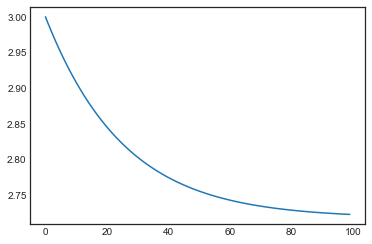

In [4]:
#solve for initial dividend by selting delta such that the interest rate is 6%
tol=1
iters = []
for i in range(100):
    iters.append(delta_0)
    Deltas = np.zeros(nu_t.shape)
    Deltas[0,:] = delta_0
    for i in range(tau):
        Deltas[i+1,:] = np.e**(alpha + mu*np.log(Deltas[i,:])+nu_t[i,:])
    E = np.log(Deltas[tau,:]/delta_0).mean()
    V = np.log(Deltas[tau,:]/delta_0).var()
    tol = r - rho + (gamma*E+0.5*(gamma**2)*V)/tau
    delta_0 = delta_0 - tol
plt.plot(iters)
tol

### Time to simulate some dividends

In [5]:
delta_0

2.7229615664621565

In [6]:
np.log(Deltas[tau,:]/delta_0).mean()

-0.0017206802917833126

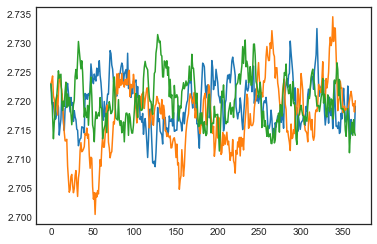

In [7]:
nu_t = sigma*(np.random.normal(0, 1, eta.shape) + (phi/(1-phi**2)**0.5)*eta)
nu_t = np.array(nu_t[t_start:t_start+dt.timedelta(days=tau)])


Deltas = np.zeros(nu_t.shape)
Deltas[0,:] = delta_0
for i in range(tau):
    Deltas[i+1,:] = np.e**(alpha + mu*np.log(Deltas[i,:])+nu_t[i,:])
plt.plot(Deltas[:,0:3]);

###  Now we take the expectations under $Q$ over each of the simulations to get the premiums
$C(t,T_1,T_2,X) = e^{-\rho(T_2-t)} \delta_t^{-\gamma}\ \mathbb{E}\big(\delta_{T_2}^{\gamma}q(X,T_1,T2)\big)$

In [8]:
def priceOptionCaoWei(t_start, tau, K, T, Tin):
    
    CDDs = np.maximum(Tin[t_start:t_start+dt.timedelta(days=tau)] - T,0)
    HDDs = np.maximum(-1*Tin[t_start:t_start+dt.timedelta(days=tau)] + T,0)
    disc = np.e**(-rho*tau)*(delta_0**(-1*gamma))
    CDDscall = disc*(((Deltas[tau,:]**gamma)*np.maximum(CDDs.sum() - K,0))).mean()
    CDDsput = disc*((Deltas[tau,:]**gamma)*np.maximum(K-CDDs.sum(),0)).mean()
    HDDscall = disc*((Deltas[tau,:]**gamma)*np.maximum(HDDs.sum() - K,0)).mean()
    HDDsput = disc*((Deltas[tau,:]**gamma)*np.maximum(K-HDDs.sum(),0)).mean()
    HDDsfutures =  disc*((Deltas[tau,:]**gamma)*HDDs.sum()).mean()
    CDDsfutures =  disc*((Deltas[tau,:]**gamma)*CDDs.sum()).mean()
    ind = ["call", 'put', "futures"]
    cols = ["HDD", 'CDD']
    prices = [(HDDscall,CDDscall), (HDDsput, CDDsput), (HDDsfutures, CDDsfutures)]
    
    return pd.DataFrame(prices, columns = cols, index = ind)
priceOptionCaoWei(t_start, tau, K, T, Tin)

,HDD,CDD
call,3631.120920,322.888804
put,0.000000,0.000000
futures,3670.494524,362.262409


### Creating a universe of derivatives 

In [9]:

def priceCaoWeiV0(t_start, tau, NumStds, T, Tin, Pin, indexType, optionType):
    #this function returns the premium for a weather derivative 
    #INPUTS:
    #t_start: starting date for derivatives
    #tau: duration of option
    #Numstds: set the strike of the option
    #T: Threshold to define index 
    #Tin, Pin: Temperature and Precipitation Monte Carlo 
    #index type and option Type: 'CDD', 'HDD', 'Precip'
    if indexType == "CDD":
        CDDs = np.maximum(Tin[t_start:t_start+dt.timedelta(days=tau)] - T,0)
        meanCDD = np.maximum(Tin[t_start:t_start+dt.timedelta(days=tau)] - T,0).sum().mean()
        stdCDD = np.maximum(Tin[t_start:t_start+dt.timedelta(days=tau)] - T,0).sum().std()
        K =  meanCDD + NumStds*stdCDD
    if indexType == "HDD":
        HDDs = np.maximum(-1*Tin[t_start:t_start+dt.timedelta(days=tau)] + T,0)
        meanHDD = np.maximum(-1*Tin[t_start:t_start+dt.timedelta(days=tau)] + T,0).sum().mean()
        stdHDD = np.maximum(-1*Tin[t_start:t_start+dt.timedelta(days=tau)] + T,0).sum().std()
        K =  meanHDD + NumStds*stdHDD
    if indexType == "Precip":
        Precip = np.maximum(Pin[t_start:t_start+dt.timedelta(days=tau)],0)
        meanPrecip = Precip.sum().mean()
        stdPrecip = Precip.sum().std()
        K =  meanPrecip + NumStds*stdPrecip
    disc = np.e**(-rho*tau)*(delta_0**(-1*gamma))
    if optionType == "call" and indexType== "CDD":
        CDDscall = disc*(((Deltas[tau,:]**gamma)*np.maximum(CDDs.sum() - K,0))).mean()
        return CDDscall
    if optionType == "put" and indexType== "CDD":
        CDDsput = disc*((Deltas[tau,:]**gamma)*np.maximum(K-CDDs.sum(),0)).mean()
        return CDDsput
    if optionType == "call" and indexType== "HDD":
        HDDscall = disc*((Deltas[tau,:]**gamma)*np.maximum(HDDs.sum() - K,0)).mean()
        return HDDscall
    if optionType == "put" and indexType== "HDD":
        HDDsput = disc*((Deltas[tau,:]**gamma)*np.maximum(K-HDDs.sum(),0)).mean()
        return HDDsput  
    if optionType == "call" and indexType== "Precip":
        Precipcall = disc*((Deltas[tau,:]**gamma)*np.maximum(Precip.sum()-K,0)).mean()
        return Precipcall
    if optionType == "put" and indexType== "Precip":
        Precipput = disc*((Deltas[tau,:]**gamma)*np.maximum(K-Precip.sum(),0)).mean()
        return Precipput     
    return -1

In [10]:
def priceCaoWeidV(t_start, tau, NumStds, T, Tin, Pin, indexType, optionType):
    #this function returns the option deltas over the period of interest  
    #INPUTS:
    #t_start: starting date for derivatives
    #tau: duration of option
    #Numstds: set the strike of the option
    #T: Threshold to define index 
    #Tin, Pin: Temperature and Precipitation Monte Carlo 
    #index type and option Type: 'CDD', 'HDD', 'Precip'
    if indexType == "CDD":
        CDDs = np.maximum(Tin[t_start:t_start+dt.timedelta(days=tau)] - T,0)
        meanCDD = np.maximum(Tin[t_start:t_start+dt.timedelta(days=tau)] - T,0).sum().mean()
        stdCDD = np.maximum(Tin[t_start:t_start+dt.timedelta(days=tau)] - T,0).sum().std()
        K =  meanCDD + NumStds*stdCDD
    if indexType == "HDD":
        HDDs = np.maximum(-1*Tin[t_start:t_start+dt.timedelta(days=tau)] + T,0)
        meanHDD = np.maximum(-1*Tin[t_start:t_start+dt.timedelta(days=tau)] + T,0).sum().mean()
        stdHDD = np.maximum(-1*Tin[t_start:t_start+dt.timedelta(days=tau)] + T,0).sum().std()
        K =  meanHDD + NumStds*stdHDD
    if indexType == "Precip":
        Precip = np.maximum(Pin[t_start:t_start+dt.timedelta(days=tau)],0)
        meanPrecip = Precip.sum().mean()
        stdPrecip = Precip.sum().std()
        K =  meanPrecip + NumStds*stdPrecip
    disc = np.e**(-rho*tau)*(delta_0**(-1*gamma))
    if optionType == "call" and indexType== "CDD":
        CDDscall = np.e**(-rho*tau)*np.maximum(CDDs.sum() - K,0) - disc*(((Deltas[tau,:]**gamma)*np.maximum(CDDs.sum() - K,0))).mean()
        return CDDscall
    if optionType == "put" and indexType== "CDD":
        CDDsput = np.e**(-rho*tau)*np.maximum(K-CDDs.sum(),0) - disc*((Deltas[tau,:]**gamma)*np.maximum(K-CDDs.sum(),0)).mean()
        return CDDsput
    if optionType == "call" and indexType== "HDD":
        HDDscall = np.e**(-rho*tau)*np.maximum(HDDs.sum() - K,0) - disc*((Deltas[tau,:]**gamma)*np.maximum(HDDs.sum() - K,0)).mean()
        return HDDscall
    if optionType == "put" and indexType== "HDD":
        HDDsput = np.e**(-rho*tau)*np.maximum(K-HDDs.sum(),0) - disc*((Deltas[tau,:]**gamma)*np.maximum(K-HDDs.sum(),0)).mean()
        return HDDsput  
    if optionType == "call" and indexType== "Precip":
        Precipcall = np.e**(-rho*tau)*np.maximum(Precip.sum() - K,0) - disc*((Deltas[tau,:]**gamma)*np.maximum(Precip.sum()-K,0)).mean()
        return Precipcall
    if optionType == "put" and indexType== "Precip":
        Precipput = np.e**(-rho*tau)*np.maximum(K-Precip.sum(),0) - disc*((Deltas[tau,:]**gamma)*np.maximum(K-Precip.sum(),0)).mean()
        return Precipput     
    return -1
NumStds = -1
indexType = "Precip"
optionType = "call"
print(priceCaoWeidV(t_start, tau, NumStds, T, Tin, Pin, indexType, optionType).mean())
print(priceCaoWeiV0(t_start, tau, NumStds, T, Tin, Pin, indexType, optionType))

-7.815322495517513
114.378629072


In [11]:
indextypes = ["HDD","CDD","Precip"]
optiontypes = ["call", "put"]
N_intervals = 5
N_strikes = 5
N_taus = 2
t_starts = [t_start + dt.timedelta(days=int(x)) for x in list(np.linspace(0,tau,N_intervals).astype(int))]
t_starts = t_starts[:-1]
taus = list(np.diff(np.linspace(0,tau,N_intervals).astype(int)))
taus = np.median(taus)
taus = [taus*(x+1) for x in range(N_taus)]
strikes = np.linspace(-2,2,N_strikes)

In [12]:
ind = pd.MultiIndex.from_product([t_starts,taus,strikes,indextypes,optiontypes],names = ['tstart', 'tau', 'strike','index','option'])
dV = pd.DataFrame(np.zeros([len(Tin.columns),len(ind)]), index = Tin.columns, columns = ind)
V0 = pd.Series(np.zeros(len(ind)), index = ind)
T = 18; #threshold
for i in range(dV.shape[1]):
    dV.iloc[:,i] = priceCaoWeidV(dV.columns[i][0], int(dV.columns[i][1]), dV.columns[i][2],
                                 T, Tin, Pin, dV.columns[i][3], dV.columns[i][4])
    V0[i] = priceCaoWeiV0(V0.index[i][0], int(V0.index[i][1]), V0.index[i][2],
                                 T, Tin, Pin, V0.index[i][3], V0.index[i][4])

In [13]:
dV.to_pickle("C:\\Users\\islipd\\Documents\\Thesis Notebooks\\dV.pkl")
V0.to_pickle("C:\\Users\\islipd\\Documents\\Thesis Notebooks\\V0.pkl")